In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
import ot
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy import linalg
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.linalg import sqrtm
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import wasserstein_distance, wasserstein_distance_nd
from sklearn import svm
from k_means_constrained import KMeansConstrained


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## WHOMP Implementation

In [22]:
def PseudoBarycenter(dependent, sensitive, threshhold):
    X_mean = []
    X_cov = []
    OT_Map = []
    X_dim = dependent.shape[1]
    Z_range = len(set(sensitive))
    X_ave = np.average(dependent, axis = 0)

    for i in range(Z_range):
        X_mean.append(np.average(dependent[sensitive == i], axis = 0))
        X_cov.append(np.cov(dependent[sensitive == i].T))

    X_barcov = np.random.rand(X_dim,X_dim)
    eps = 1000
    while eps > threshhold:
        X_new = np.zeros((X_dim, X_dim))
        for i in range(Z_range):
            X_new = X_new + (1/Z_range) * sqrtm(sqrtm(X_barcov) @ X_cov[i] @ sqrtm(X_barcov))
        eps = np.linalg.norm(X_new - X_barcov)
        X_barcov = X_new

    X_bar = np.zeros(dependent.shape)
    for i in range(Z_range):
        transport = np.linalg.inv(sqrtm(X_cov[i])) @ sqrtm( sqrtm(X_cov[i]) @ X_barcov @ sqrtm(X_cov[i]) ) @ np.linalg.inv(sqrtm(X_cov[i]))
        OT_Map.append(transport)
        X_bar[sensitive == i] = (dependent[sensitive == i] - X_mean[i]) @ transport.T + X_ave

    return X_bar

def RandomPartition(X_toy, subgroup_number):
    random_index = np.zeros(len(X_toy))
    index = np.arange(len(X_toy))
    random.shuffle(index)
    random_subgroup = np.array_split(index, subgroup_number)
    for i in range(subgroup_number):
        random_index[random_subgroup[i]] = i
    return random_index

def Barycenter_Fixed_Point_LP(data, sensitive, threshhold):

    ## Initialization
    data_card, feature_dim = data.shape
    # Pick centroid as the overall average
    data_mean = np.average(data, axis = 0)
    sensitive_var_list = []
    sensitive_group_card_list = []
    # Pick variance as the smallest L2 norm among all sensitive groups
    sensitive_label = list(set(sensitive))
    sensitive_card = len(sensitive_label)
    for i in range(sensitive_card):
        sensitive_group = data[sensitive == sensitive_label[i],:]
        sensitive_group_card_list.append(sensitive_group.shape[0])
        sensitive_var_list.append(np.average(np.linalg.norm(sensitive_group,axis = 1)**2)**0.5)
    if len(set(sensitive_group_card_list)) > 1:
        return "Sensitive groups require to share the same cardinality."
        
    sensitive_group_card = sensitive_group_card_list[0]
    min_var = min(sensitive_var_list)
    # sample from Gaussian as initilization
    X_bar = np.random.multivariate_normal(data_mean, min_var*np.identity(feature_dim), sensitive_group_card)

    ## Iterative method to find the barycenter
    eps = threshhold + 1
    max_iter = 5000
    iter = 0
    while eps > threshhold and iter < max_iter:
        X_bar_new = np.zeros(X_bar.shape)
        X_bar_index = np.arange(sensitive_group_card)
        # Find the OT matching from X_bar to each sensitive group, then find the centroid of the matched points to update the barycenter
        match_list = []
        for i in range(sensitive_card):
            sensitive_group_index = np.where(sensitive == sensitive_label[i])[0]
            sensitive_group = data[sensitive_group_index,:]
            density_group = density_Xbar = np.ones(sensitive_group_card)
            cost_matrix = ot.dist(X_bar, sensitive_group)
            plan = np.array(ot.emd(density_Xbar, density_group, cost_matrix),dtype=int)
            match_index = plan @ X_bar_index
            match_list.append(sensitive_group_index[match_index])
            for j in range(sensitive_group_card):
                X_bar_new[j,:] += sensitive_group[match_index[j],:]
        X_bar_new = X_bar_new/sensitive_card

        # Update the distance between X_bar and the new one for the stop criteria
        cost_matrix_eps = ot.dist(X_bar, X_bar_new)
        plan_eps = np.array(ot.emd(density_Xbar/sensitive_group_card, density_group/sensitive_group_card, cost_matrix))
        eps = np.sqrt(np.sum(cost_matrix_eps*plan_eps))
        #var_Xbar = np.average(np.linalg.norm(X_bar, axis = 1)**2)**0.5
        #var_Xbar_new = np.average(np.linalg.norm(X_bar_new, axis = 1)**2)**0.5
        #eps = abs(var_Xbar - var_Xbar_new)
        iter += 1
        X_bar = X_bar_new
        match_list = (np.array(match_list)).T
    
    return X_bar, match_list

def WHOMP_LP(data, subgroup_number, threshold):
    sample_size = data.shape[0]
    clf = KMeansConstrained(n_clusters= int(sample_size/subgroup_number),size_min=subgroup_number,size_max=subgroup_number,n_init = 500, max_iter = 10000, tol = 0.000000001, random_state=None)
    clf.fit_predict(data)
    label = clf.labels_
    barycenter, OT_plan_list = Barycenter_Fixed_Point_LP(data, label, threshold)
    matched_list = OT_plan_list
    return barycenter, matched_list

def RandomAntiClustering_Exact(data, subgroup_number):
    sample_size = data.shape[0]
    clf = KMeansConstrained(n_clusters= int(sample_size/subgroup_number),size_min=subgroup_number,size_max=subgroup_number,n_init = 500, max_iter = 10000, tol = 0.000000001, random_state=None)
    clf.fit_predict(data)
    label = clf.labels_
    anticluster_index = np.zeros(sample_size)-1
    for i in range(len(set(label))):
        index_i = np.where(label == i)[0]
        random.shuffle(index_i)
        index_i_select = np.array_split(index_i, subgroup_number)
        for j in range(subgroup_number):
            anticluster_index[index_i_select[j]] = j

    return anticluster_index

## Pocock and Simon's Covariate-adaptive Randomizatiom Implementation

In [23]:
class PocockSimonsMinimizationMultiTreatment:
    def __init__(self, covariates, treatments, num_treatments, imbalance_prob=0.8):
        """
        Initializes the Pocock and Simon's minimization class for multiple treatments.

        Parameters:
        - covariates: List of tuples containing the covariate values for each subject so far.
        - treatments: List containing the treatment assignments (integers starting from 0) for each subject so far.
        - num_treatments: The number of treatment groups.
        - imbalance_prob: Probability of assigning to the treatment that minimizes imbalance (default 0.8).
        """
        self.covariates = np.array(covariates)
        self.treatments = np.array(treatments)
        self.num_treatments = num_treatments
        self.imbalance_prob = imbalance_prob

    def calculate_imbalance_score(self, treatment, new_covariate):
        """
        Calculate imbalance score for a given potential treatment assignment.

        Parameters:
        - treatment: Treatment group being evaluated (integer starting from 0).
        - new_covariate: Covariates of the new subject.

        Returns:
        - Imbalance score.
        """
        imbalance_score = 0

        # Iterate over each covariate
        for i in range(self.covariates.shape[1]):
            treatment_sums = []
            for t in range(self.num_treatments):
                existing_sum = np.sum(self.covariates[self.treatments == t, i])
                if t == treatment:
                    existing_sum += new_covariate[i]
                treatment_sums.append(existing_sum)
            
            # Calculate imbalance as the range (max - min) of sums
            imbalance_score += max(treatment_sums) - min(treatment_sums)

        return imbalance_score

    def assign_treatment(self, new_covariate):
        """
        Assign treatment to a new subject based on Pocock and Simon's method with multiple treatments.

        Parameters:
        - new_covariate: Covariates of the new subject.

        Returns:
        - Treatment assignment (integer representing the treatment group).
        """
        imbalance_scores = []
        
        # Calculate imbalance scores for each possible treatment group
        for t in range(self.num_treatments):
            imbalance_score = self.calculate_imbalance_score(t, new_covariate)
            imbalance_scores.append(imbalance_score)
        
        # Find the treatment with the minimum imbalance score
        min_score = min(imbalance_scores)
        min_treatments = [t for t, score in enumerate(imbalance_scores) if score == min_score]
        
        if len(min_treatments) == 1:
            best_treatment = min_treatments[0]
        else:
            best_treatment = np.random.choice(min_treatments)  # Randomly choose among the best
        
        # Assign with imbalance_prob to the best treatment, otherwise to a random one
        if np.random.rand() < self.imbalance_prob:
            return best_treatment
        else:
            return np.random.choice(range(self.num_treatments))
        
class MinimizationAlgorithm:
    def __init__(self, num_treatments, max_group_size):
        self.num_treatments = num_treatments
        self.max_group_size = max_group_size
        self.group_sizes = np.zeros(num_treatments)
    
    def assign_treatment(self, covariate, group, treatment):
        # Pocock-Simon minimization logic, adding constraint for group sizes
        # Example placeholder (modify with actual minimization logic)
        eligible_treatments = [i for i in range(self.num_treatments) if self.group_sizes[i] < self.max_group_size]
        if not eligible_treatments:
            raise ValueError("All groups are full.")

        # Minimize discrepancy for eligible treatments
        # Here you would calculate imbalance for eligible treatments
        assigned_treatment = random.choice(eligible_treatments)  # Replace this with minimization logic
        
        # Update the group sizes
        self.group_sizes[assigned_treatment] += 1
        return assigned_treatment

def Pocock_Simon_minimization(covariates, num_treatments):
    treatment_assignment = np.zeros(covariates.shape[0], dtype=int)
    index_shuffle = np.arange(covariates.shape[0])
    random.shuffle(index_shuffle)
    
    # Set the maximum group size for balanced groups
    max_group_size = covariates.shape[0] // num_treatments
    
    # Initialize treatment assignments for the first few participants
    ini_treatment = np.arange(num_treatments)
    treatment_assignment[index_shuffle[:num_treatments]] = ini_treatment
    
    # Create the minimization algorithm instance with group size enforcement
    minimization = MinimizationAlgorithm(num_treatments=num_treatments, max_group_size=max_group_size)
    
    # Update the group sizes for the initial assignments
    minimization.group_sizes += 1  # As each treatment got 1 participant
    
    # Start assigning the rest of the participants
    for i in range(num_treatments, covariates.shape[0]):
        # Subset of participants assigned so far
        treatment = treatment_assignment[index_shuffle[:i]]
        group = covariates[index_shuffle[:i], :]
        
        # Assign the next participant, enforcing group size balancing
        assigned_treatment = minimization.assign_treatment(covariates[index_shuffle[i], :], group, treatment)
        treatment_assignment[index_shuffle[i]] = assigned_treatment
    
    return treatment_assignment


## Comparison Test Implementation

In [24]:
def HoldoutSet(X, y, holdoutindex):
    X_holdout = X[holdoutindex == 1]
    X_comp = X[holdoutindex != 1]
    y_holdout = y[holdoutindex == 1]
    y_comp = y[holdoutindex != 1]
    return X_holdout, X_comp, y_holdout, y_comp

def RandomSubgroupSet(X, y, subgroupindex):
    shuffle = np.arange((len(set(subgroupindex))))
    random.shuffle(shuffle)
    X_holdout = X[subgroupindex == shuffle[1]]
    X_comp = X[subgroupindex == shuffle[0]]
    y_holdout = y[subgroupindex == shuffle[1]]
    y_comp = y[subgroupindex == shuffle[0]]
    return X_holdout, X_comp, y_holdout, y_comp

def RandomSubgroupSet_Complement(X, y, subgroupindex):
    shuffle = np.arange((len(set(subgroupindex))))
    random.shuffle(shuffle)
    X_holdout = X[subgroupindex == shuffle[1]]
    X_comp = X[subgroupindex != shuffle[1]]
    y_holdout = y[subgroupindex == shuffle[1]]
    y_comp = y[subgroupindex != shuffle[1]]
    return X_holdout, X_comp, y_holdout, y_comp

## Load Data

In [25]:
df = pd.read_csv('/Users/shizhouxu/Desktop/SX_Workspace/Diverse_Subgroups/NPI/NPI_dataset/data.csv')
df

,score,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,elapse,gender,age
0,18,2,2,2,2,1,2,1,2,2,...,1,1,2,2,2,1,2,211,1,50
1,6,2,2,2,1,2,2,1,2,1,...,2,1,2,2,2,2,1,149,1,40
2,27,1,2,2,1,2,1,2,1,2,...,1,2,1,1,2,1,2,168,1,28
3,29,1,1,2,2,2,1,2,1,1,...,1,2,1,2,2,1,1,230,1,37
4,6,1,2,1,1,1,2,1,2,1,...,2,1,2,2,2,0,1,389,1,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11238,1,2,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,243,1,24
11239,10,2,2,1,1,1,2,1,1,1,...,2,1,2,1,2,2,1,197,1,39
11240,6,1,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,447,2,33
11241,12,2,2,1,1,1,1,1,1,1,...,1,2,2,2,2,2,1,167,1,24


In [26]:
X = df.to_numpy()[:,1:41]
Gender = df['gender'].to_numpy()
Score = df['score'].to_numpy()
Gender = Gender[~np.any(X == 0, axis=1)]
Score = Score[~np.any(X == 0, axis=1)]
X = X[~np.any(X == 0, axis=1)]

## Wasserstein Experiment

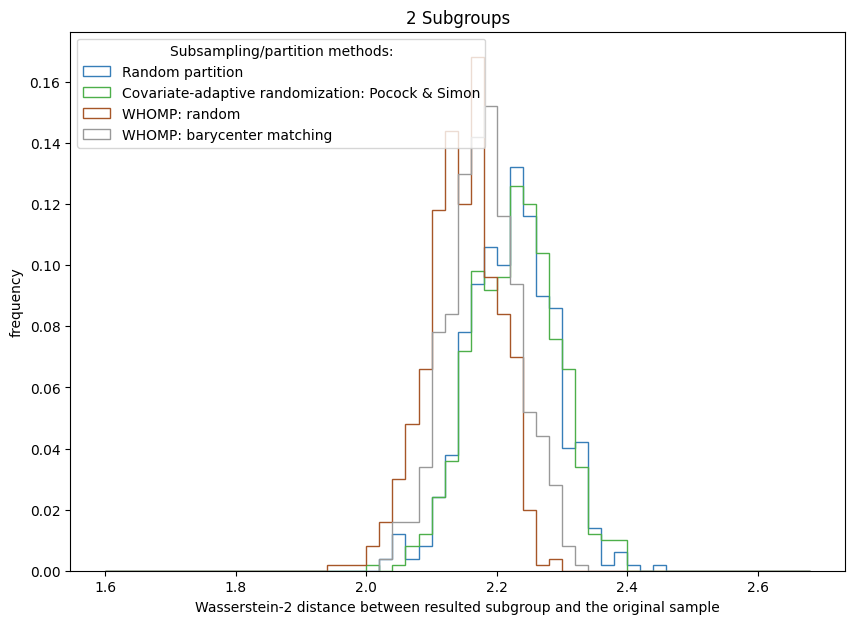

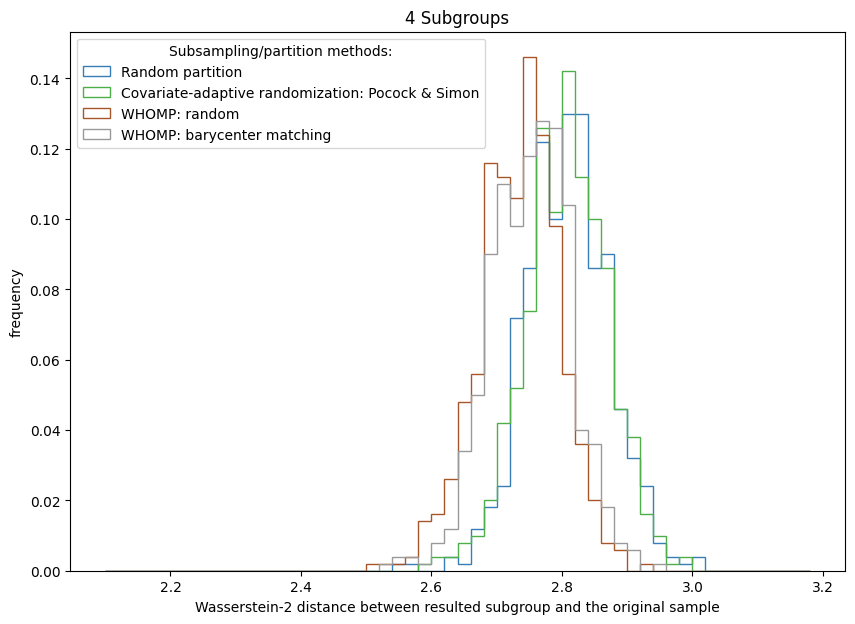

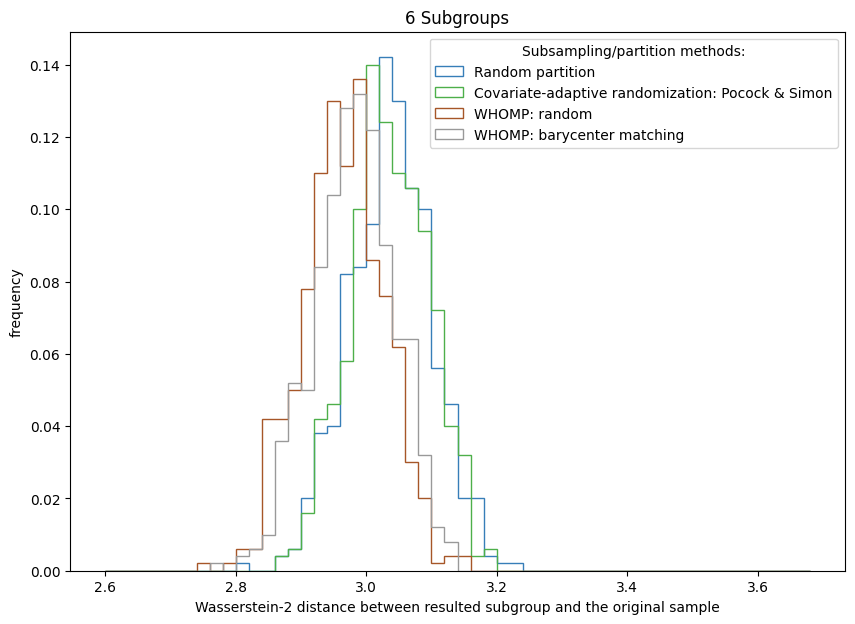

In [47]:
random_error_ave = []
PS_error_ave = []
anticluster_error_ave = []
WHOMP_error_ave = []

random_error_std = []
PS_error_std = []
anticluster_error_std = []
WHOMP_error_std = []

random_error_list = []
PS_error_list = []
anticluster_error_list = []
WHOMP_error_list = []

random_mean_list = []
PS_mean_list = []
anti_mean_list = []
bary_mean_list = []

random_var_list = []
PS_var_list = []
anti_var_list = []
bary_var_list = []

for k in range(2,7,2):

    random_error = []
    PS_error = []
    anticluster_error = []
    WHOMP_error = []

    mean_random = []
    var_random = []
    mean_PS = []
    var_PS = []
    mean_anti = []
    var_anti = []
    mean_bary = []
    var_bary = []

    for s in range(500):

        # data from NPI
        index_shuffle = np.arange(X.shape[0])
        np.random.shuffle(index_shuffle)
        X_toy = X[index_shuffle[:60],:]
        truth_model = np.zeros(X_toy.shape[0])
        subgroup_number = k

        barycenter, barysample_index = WHOMP_LP(X_toy, subgroup_number , 0.00000001)
        PS_index = Pocock_Simon_minimization(X_toy, subgroup_number)
        anticluster_index = RandomAntiClustering_Exact(X_toy, subgroup_number=subgroup_number)
        random_index = RandomPartition(X_toy, subgroup_number=subgroup_number)

        X_bary = X_toy[barysample_index[0],:]
        density_sensitive = np.ones(X_bary.shape[0])/X_bary.shape[0]
        density_X = np.ones(X_toy.shape[0])/X_toy.shape[0]
        
        eps_random = 0
        for i in range(subgroup_number):
            X_random = X_toy[random_index == i,:]
            cost_matrix_random = ot.dist(X_toy, X_random)
            plan_random = np.array(ot.emd(density_X, density_sensitive, cost_matrix_random))
            eps_random += np.sum(cost_matrix_random*plan_random)
            mean_random.append(np.average(X_random))
            var_random.append(np.var(X_random))


        eps_PS = 0
        for i in range(subgroup_number):
            X_ps = X_toy[PS_index == i,:]
            cost_matrix_PS = ot.dist(X_toy, X_ps)
            plan_PS = np.array(ot.emd(density_X, density_sensitive, cost_matrix_PS))
            eps_PS += np.sum(cost_matrix_PS*plan_PS)
            mean_PS.append(np.average(X_ps))
            var_PS.append(np.var(X_ps))
        
        
        eps_anti = 0
        for i in range(subgroup_number):
            X_anti = X_toy[anticluster_index == i,:]
            cost_matrix_anti = ot.dist(X_toy, X_anti)
            plan_anti = np.array(ot.emd(density_X, density_sensitive, cost_matrix_anti))
            eps_anti += np.sum(cost_matrix_anti*plan_anti)
            mean_anti.append(np.average(X_anti))
            var_anti.append(np.var(X_anti))

        
        eps_bary = 0
        for i in range(subgroup_number):
            X_bary = X_toy[barysample_index[i],:]
            cost_matrix_bary = ot.dist(X_toy, X_bary)
            plan_bary = np.array(ot.emd(density_X, density_sensitive, cost_matrix_bary))
            eps_bary += np.sum(cost_matrix_bary*plan_bary)
            mean_bary.append(np.average(X_bary))
            var_bary.append(np.var(X_bary))

        random_error.append(np.sqrt(eps_random/subgroup_number))
        PS_error.append(np.sqrt(eps_PS/subgroup_number))
        anticluster_error.append(np.sqrt(eps_anti/subgroup_number))
        WHOMP_error.append(np.sqrt(eps_bary/subgroup_number))

    random_error_list.append(random_error)
    PS_error_list.append(PS_error)
    anticluster_error_list.append(anticluster_error)
    WHOMP_error_list.append(WHOMP_error)
 
    random_error_ave.append(np.average(random_error))
    PS_error_ave.append(np.average(PS_error))
    anticluster_error_ave.append(np.average(anticluster_error))
    WHOMP_error_ave.append(np.average(WHOMP_error))

    random_error_std.append(np.std(random_error))
    PS_error_std.append(np.std(PS_error))
    anticluster_error_std.append(np.std(anticluster_error))
    WHOMP_error_std.append(np.std(WHOMP_error))

    random_mean_list.append(mean_random)
    PS_mean_list.append(mean_PS)
    anti_mean_list.append(mean_anti)
    bary_mean_list.append(mean_bary)

    random_var_list.append(var_random)
    PS_var_list.append(var_PS)
    anti_var_list.append(var_anti)
    bary_var_list.append(var_bary)

    fig = plt.figure(figsize =(10, 7))
    xbins = np.arange(1.6+(k-2)*0.25, 2.7+(k-2)*0.25, 0.02)
 
    plt.hist(random_error, bins = xbins, density=False, weights= 1/len(random_error) * np.ones(len(random_error)), histtype='step', color = '#377eb8', label='Random partition')
    plt.hist(PS_error, bins = xbins, density=False, weights= 1/len(PS_error) * np.ones(len(PS_error)), histtype='step', color = '#4daf4a', label='Covariate-adaptive randomization: Pocock & Simon')
    plt.hist(anticluster_error, bins = xbins, density=False, weights= 1/len(anticluster_error) * np.ones(len(anticluster_error)), histtype='step', color = '#a65628', label='WHOMP: random')
    plt.hist(WHOMP_error, bins = xbins, density=False, weights= 1/len(WHOMP_error) * np.ones(len(WHOMP_error)), histtype='step', color = '#999999', label='WHOMP: barycenter matching')

    plt.xlabel('Wasserstein-2 distance between resulted subgroup and the original sample')
    plt.ylabel('frequency')
    plt.legend(fontsize='medium', title='Subsampling/partition methods:')

    plt.title("{} Subgroups".format(k)) 
 
    # show plot
    plt.show()

In [63]:
size_start = [1.9, 2.4, 2.7]
size_end = [2.5, 3.1, 3.3]

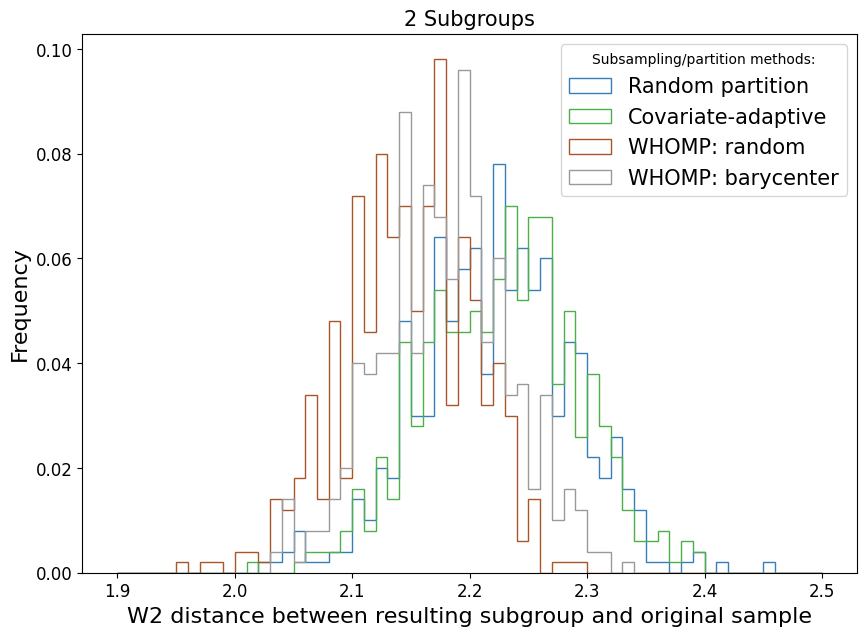

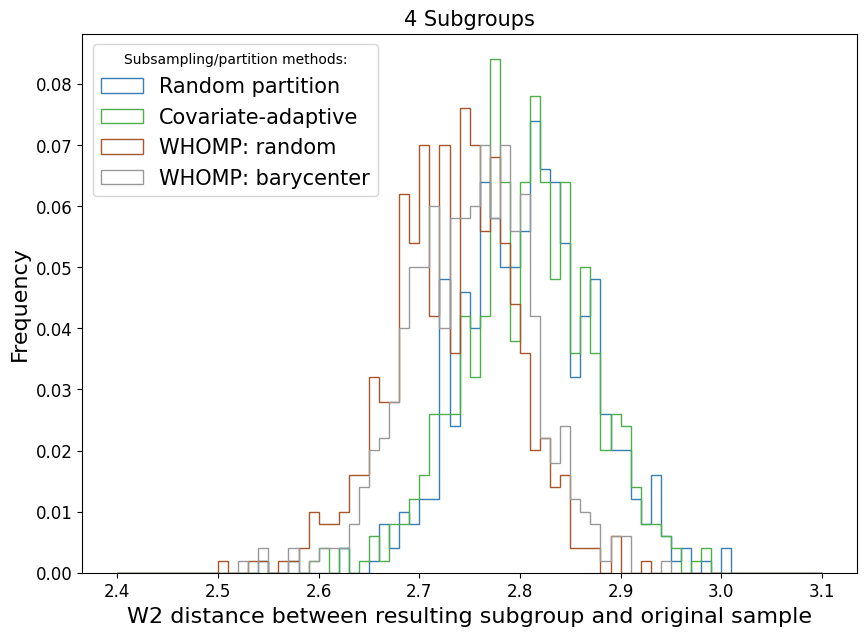

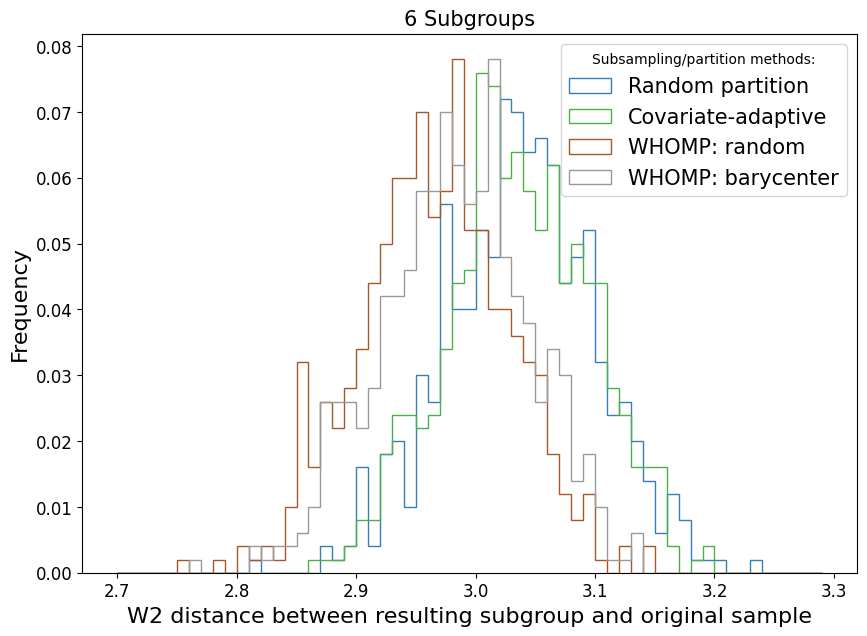

In [67]:
for i in range(0,3):
    k = (i+1)*2

    fig = plt.figure(figsize =(10, 7))
    xbins = np.arange(size_start[i], size_end[i], 0.01)

    random_error = random_error_list[i]
    PS_error = PS_error_list[i]
    anticluster_error = anticluster_error_list[i]
    WHOMP_error = WHOMP_error_list[i]
 
    plt.hist(random_error, bins = xbins, density=False, weights= 1/len(random_error) * np.ones(len(random_error)), histtype='step', color = '#377eb8', label='Random partition')
    plt.hist(PS_error, bins = xbins, density=False, weights= 1/len(PS_error) * np.ones(len(PS_error)), histtype='step', color = '#4daf4a', label='Covariate-adaptive')
    plt.hist(anticluster_error, bins = xbins, density=False, weights= 1/len(anticluster_error) * np.ones(len(anticluster_error)), histtype='step', color = '#a65628', label='WHOMP: random')
    plt.hist(WHOMP_error, bins = xbins, density=False, weights= 1/len(WHOMP_error) * np.ones(len(WHOMP_error)), histtype='step', color = '#999999', label='WHOMP: barycenter')

    plt.xlabel('W2 distance between resulting subgroup and original sample', fontsize = 16)
    plt.ylabel('Frequency', fontsize = 16)
    plt.legend(fontsize=15, title='Subsampling/partition methods:')
    plt.tick_params(axis='both', labelsize=12)

    plt.title("{} Subgroups".format(k), fontsize = 15) 
 
    # show plot
    plt.show()
    

In [48]:
random_error_ave, PS_error_ave, anticluster_error_ave, WHOMP_error_ave

([2.2222446499527297, 2.807811856512091, 3.0370687658387796],
 [2.22661443051338, 2.8059490269608216, 3.0356261928687736],
 [2.1479586586154786, 2.7338648859057852, 2.9653223670942834],
 [2.178622840645431, 2.751197233730786, 2.982381064908577])

In [49]:
random_error_std, PS_error_std, anticluster_error_std, WHOMP_error_std

([0.06477177180791856, 0.06449220958213696, 0.06255646702386264],
 [0.06445808324983553, 0.06390141963173157, 0.0601503251319621],
 [0.05453073334179316, 0.061774743582473854, 0.06268912088253534],
 [0.055098562153348254, 0.061620730646448296, 0.062208121185664274])

In [45]:
for i in range(3):
    print((np.var(np.array(bary_var_list[i])), np.var(np.array(anti_var_list[i])), np.var(np.array(PS_var_list[i])), np.var(np.array(random_var_list[i]))))

(3.0903662820167824e-07, 1.8819411776186333e-07, 2.7389937849103003e-07, 2.3479903538532098e-07)
(7.729807298437504e-07, 4.2945595246720867e-07, 6.121259142727635e-07, 6.589114478375779e-07)
(1.3220811717664837e-06, 7.842920180164869e-07, 1.20871168228732e-06, 1.189920859335928e-06)


In [46]:
for i in range(3):
    print((np.var(np.array(bary_mean_list[i])), np.var(np.array(anti_mean_list[i])), np.var(np.array(PS_mean_list[i])), np.var(np.array(random_mean_list[i]))))

(0.00022583272152777785, 0.00014620355486111107, 0.0001865007770833333, 0.0001870938326388889)
(0.00040828391597222223, 0.0002670728048611111, 0.00035493113819444434, 0.00037207280486111107)
(0.0005724590104166666, 0.00040985901041666676, 0.0005587006770833334, 0.0005546298437499999)
